<img src="./pics/DL.png" width=110 align="left" style="margin-right: 10px">

# Deep Learning w/ Python

## Home Assignment I. by Kristof Rabay - ANN

---

## Silent MNIST

<p><a href="https://commons.wikimedia.org/wiki/File:%D9%84%D8%BA%D8%A9_%D8%A7%D9%84%D8%A7%D8%B4%D8%A7%D8%B1%D8%A9_%D8%A7%D9%84%D8%A7%D9%85%D8%B1%D9%8A%D9%83%D9%8A%D8%A9.png#/media/File:لغة_الاشارة_الامريكية.png"><img src="./pics/exercises/silent_mnist.png" width=400></a><br>By <a href="//commons.wikimedia.org/w/index.php?title=User:Krzys_kurd&amp;action=edit&amp;redlink=1" class="new" title="User:Krzys kurd (page does not exist)">Krzys kurd</a> - <span class="int-own-work" lang="en">Own work</span>, <a href="https://creativecommons.org/licenses/by-sa/3.0" title="Creative Commons Attribution-Share Alike 3.0">CC BY-SA 3.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=24699115">Link</a></p>

### Description

Create a silent number detector using the different pictures taken of the signers hands. Your task is to create a neural network to solve this problem, using dense layers. You are free to use any kind of preprocessing or any kind of transformation on the data, and you can use any discussed methods.  
Your designed solution must be presented in a form of clean, structured and well commented code. Descriptions should include the designed network layouts and the reasoning behind the choices. The final results should be highlighted, saved ([tutorial](https://machinelearningmastery.com/save-load-keras-deep-learning-models/)) and easily reproduceable.  
Creating parametrizable functions to dynamically generate networks is a plus.

### About the data

The pictures are already preprocessed and transformed into greyscale image matrices.  
The target variable is the value of the associated sign in one-hot encoded form.  
Both feature matrix and target vectors are available as numpy arrays and can be found in the `data/sign_language/` folder. You can read `.npy` numpy array files with the `np.load("path_to_file.npy")` function.

# Solution

## 1. Let's read in the data to work with

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
os.getcwd()

'C:\\Users\\Krisz\\Desktop\\ceu\\materials\\spring\\dl_py\\deep_learning'

In [3]:
os.chdir("data/sign_language/")
os.listdir()

['model.png', 'references.md', 'X.npy', 'y.npy']

In [4]:
X = np.load("X.npy")
y = np.load("y.npy")

## 2. How does the data look like?

2062 images to train and to test with, respectively

X: 64x64 numpy arrays (1 color, 64 * 64 pixels)

y: 1x10 numpy arrays (10 possible outcomes)

In [5]:
X.shape, y.shape

((2062, 64, 64), (2062, 10))

In [6]:
X[:1], y[:1]

(array([[[0.47450978, 0.46274507, 0.45098037, ..., 0.50196075,
          0.5137255 , 0.52549016],
         [0.46666664, 0.45098037, 0.43921566, ..., 0.4980392 ,
          0.5098039 , 0.52156866],
         [0.45490193, 0.43921566, 0.42745095, ..., 0.49411762,
          0.50196075, 0.517647  ],
         ...,
         [0.4470588 , 0.4352941 , 0.4235294 , ..., 0.49019605,
          0.4980392 , 0.5058824 ],
         [0.45490193, 0.44313723, 0.43137252, ..., 0.4980392 ,
          0.5058824 , 0.5137255 ],
         [0.46274507, 0.45098037, 0.43921566, ..., 0.50196075,
          0.5098039 , 0.52156866]]], dtype=float32),
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32))

Let's visualize the 1st one to see the actual image!

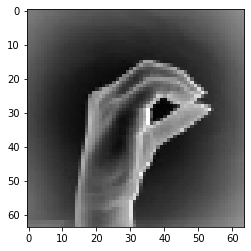

In [7]:
plt.imshow(np.squeeze(X[1]), cmap="gray")
plt.show()

## 3. Importing everything I'll be working with via the Keras API and scikit-learn

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD, Adam
from keras.regularizers import l1, l2
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from livelossplot import PlotLossesKeras

Using TensorFlow backend.


In [9]:
from sklearn.model_selection import train_test_split

## 4. Splitting the X and y to train-test sets

It's more important for the model to be generally 'good' (on lots of test datasets) rather than be great on only one dataset.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20202020)

Let's check if we still see images

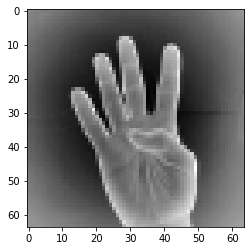

In [11]:
plt.imshow(X_train[0], cmap = 'gray')

In [12]:
X_train.shape, y_train.shape

((1649, 64, 64), (1649, 10))

We're not training CNNs, so let's reshape the arrays to vectors

In [13]:
input_shape = 64 * 64

X_train = X_train.reshape((X_train.shape[0], input_shape)).astype('float32')
X_test = X_test.reshape((X_test.shape[0], input_shape)).astype('float32')

I turned the 2062 image arrays into 1649 train + 413 test vectors

In [14]:
X_train.shape, X_test.shape

((1649, 4096), (413, 4096))

## 5. Setting up and fitting the model

In [15]:
output_classes = y_train.shape[1] # have 10 classes to predict

#### Structure

- I'll build a simple ANN with Keras API
- I'll use 2 dense hidden layers, activated by sigmoid
- For the hidden layers I'll apply l1 regularization on the neurons (not the bias)
- I'll use dropout layers for further generalization - dropout rate will be set to 25%
- My output layer will be activated by softmax (due to >2 categories to predict)

#### Compilation

- Categorical Cross-Entropy will be used as a loss f(x) (output has been one-hot encoded)
- Adam will be leveraged for optimization (keeping default learning rate at 0.001)
- Will be monitoring Accuracy

#### Callbacks used

- I want to change / stop training once validation loss doesn't decrease further
1. Learning rate reduction - if for 5 consecutive epochs validation loss doesn't decrease, I'll decrease LR by 1/3
2. Early stopping metric - if for 10 consecutive epochs validation loss doesn't decrease, training stops

#### Validation

- Will be using 20% of train data as validation set (test is held out for final evaluation)

In [16]:
model = Sequential()

# first hidden layer
model.add(Dense(128, input_dim = input_shape, 
                activation = 'sigmoid', 
                kernel_regularizer = l1(1e-5)))
model.add(Dropout(0.25))

# second hidden layer
model.add(Dense(128, activation = 'sigmoid', 
                kernel_regularizer = l1(1e-5)))
model.add(Dropout(0.25))

# output layer
model.add(Dense(output_classes, activation = 'softmax'))

# compile the model
model.compile(loss = 'categorical_crossentropy', 
              optimizer = 'adam', 
              metrics = ['accuracy'])

In [17]:
callbacks = [PlotLossesKeras(),
             EarlyStopping(monitor = 'val_loss', patience = 10),
             ReduceLROnPlateau(monitor = 'val_loss', patience = 5, factor = 1/3)]

In [18]:
#plot_model(model, show_shapes=True, show_layer_names=True)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               524416    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 542,218
Trainable params: 542,218
Non-trainable params: 0
_________________________________________________________________


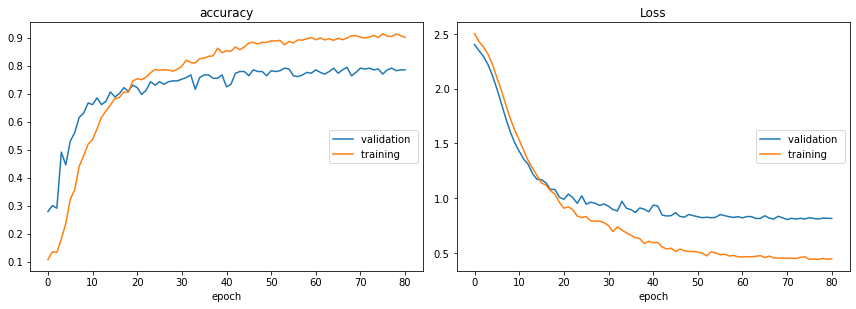

accuracy
	validation       	 (min:    0.279, max:    0.794, cur:    0.785)
	training         	 (min:    0.108, max:    0.914, cur:    0.901)
Loss
	validation       	 (min:    0.806, max:    2.403, cur:    0.816)
	training         	 (min:    0.441, max:    2.501, cur:    0.448)


In [19]:
model.fit(X_train, 
          y_train, 
          batch_size = 64, 
          epochs = 100, 
          validation_split = 0.2, 
          verbose = 1,
          callbacks = callbacks)

## 6. Evaluating on the test set

Train accuracy reached 90%, while validation was around 80%. Test accuracy is also around 80%, so generalization worked, the model seems to perform similarly on validational data sets. 80% is not great, but for an ANN it's actually quite good in my opinion. CNN shall break into the 90-95% test accuracy tho!

In [20]:
test_acc = model.evaluate(X_test, y_test, verbose = 0)[1]
print("Accuracy on test set: ","{:.2%}".format(test_acc))

Accuracy on test set:  80.15%


## 7. Saving model

No need to re-train the model again

In [21]:
model.save("../../../assignment_1/silent_mnist_model.h5")

In [ ]:
# to load
# model = load_model("../../../assignment_1/silent_mnist_model.h5")